## Governing Equation:
$$
\dfrac{-1}{2}\dfrac{d^2 \psi(x)}{d x^2} + \dfrac{1}{2}\psi(x) x^2 = 0
$$

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

In [7]:
def derivative(y,t):
    return torch.autograd.grad(
        y,t,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True
    )[0]

In [8]:
class PINN(nn.Module):
    def __init__(self,hidden_dim=40,hidden_layers=3):
        super(PINN, self).__init__()
        layers=[]
        layers.append(nn.Linear(1,hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(hidden_layers-1):
            layers.append(nn.Linear(hidden_dim,hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim,1))
        self.net=nn.Sequential(*layers)
    def forward(self,t):
        return self.net(t)

In [15]:
x=torch.linspace(-5,5,200).view(-1,1).requires_grad_(True)

In [16]:
model=PINN()
E = torch.nn.Parameter(torch.tensor([0.5], requires_grad=True))
optimizer = torch.optim.Adam(list(model.parameters()) + [E], lr=1e-3)

In [ ]:
def loss_fn():
    psi=model(x)
    dpsi_dx =derivative(psi, x)
    d2psi_dx2= derivative(dpsi_dx, x)
    V=0.5*x**2
    residual =-0.5*d2psi_dx2+V*psi-E*psi
    norm=torch.mean(psi**2)
    loss=torch.mean(residual**2)+10*(norm - 1)**2
    return loss

In [24]:
loss_hist=[]
for epoch in range(10000):
    optimizer.zero_grad()
    loss = loss_fn()
    loss.backward()
    optimizer.step()
    if epoch % 2000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.3e}, E = {E.item():.5f}")
        loss_hist.append(loss.item())


Epoch 0: Loss = 1.932e-05, E = 0.49999
Epoch 2000: Loss = 9.919e-06, E = 0.50000
Epoch 4000: Loss = 1.260e-05, E = 0.50000
Epoch 6000: Loss = 7.455e-04, E = 0.49996
Epoch 8000: Loss = 1.337e-04, E = 0.50001


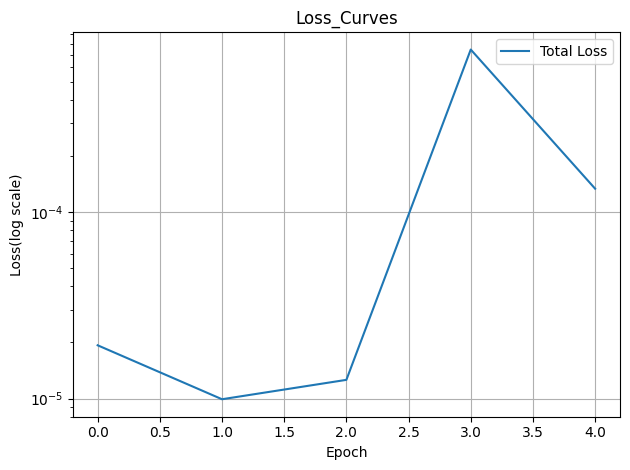

In [25]:
plt.plot(np.array(loss_hist),label="Total Loss")
# plt.plot(np.array(boundary1_losses),label="Boundary 1 Loss")
# plt.plot(np.array(boundary2_losses),label="Boundary 2 Loss")
# plt.plot(np.array(phys_losses),label="Physics Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss(log scale)")
plt.title("Loss_Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

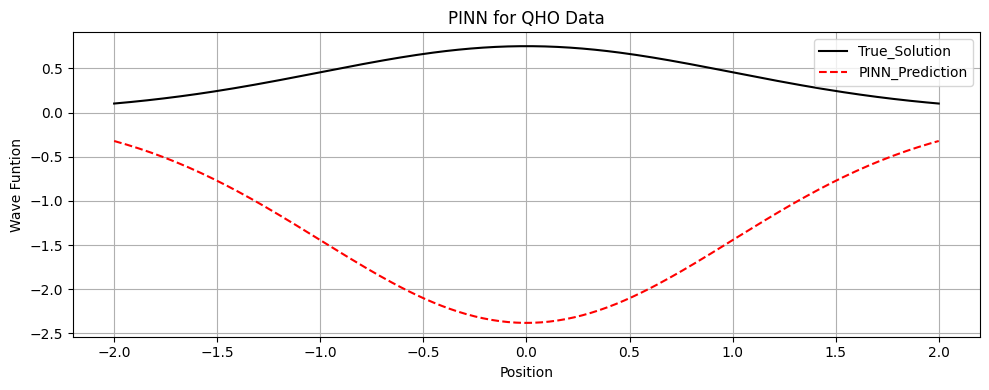

In [28]:
#Evaluation
x_test = torch.linspace(-2, 2, 200).view(-1,1).requires_grad_(True)
x_pred = model(x_test).detach().numpy()
#x_true = true_solution(t_test.detach().numpy().flatten(), x0, v0, omega)
x_true = (1/np.pi**0.25) * np.exp(-x_test.detach()**2 / 2)
plt.figure(figsize=(10,4))
plt.plot(x_test.detach(),x_true,'k-',label="True_Solution")
plt.plot(x_test.detach(),x_pred,'r--',label="PINN_Prediction")
#plt.scatter(t_data.detach(),x_data.detach(),c='blue',label="Noisy_Data_Points",s=30,alpha=0.5)
plt.legend()
plt.xlabel("Position")
plt.ylabel("Wave Funtion")
plt.title("PINN for QHO Data")
plt.grid(True)
plt.tight_layout()
plt.show()